In [3]:
import os
import pywt

import MyEDFImports as m
import numpy as np
import matplotlib.pyplot as plt
import neurokit2

In [4]:
data = m.load_all_data()
labels = m.load_all_labels()
data.shape

Extracting EDF parameters from /home/tadeusz/Desktop/Tadeusz/mgr_sleep_states/Jean-Pol_repaired_headers/CN223100.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from /home/tadeusz/Desktop/Tadeusz/mgr_sleep_states/Jean-Pol_repaired_headers/CP229110.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from /home/tadeusz/Desktop/Tadeusz/mgr_sleep_states/Jean-Pol_repaired_headers/CX230050.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from /home/tadeusz/Desktop/Tadeusz/mgr_sleep_states/Jean-Pol_repaired_headers/DG220020.edf...
EDF file detected
Setting chann

/home/tadeusz/Desktop/Tadeusz/mgr_sleep_states/MyEDFImports.py:42: RuntimeWarning: Channel names are not unique, found duplicates for: {'CHIN EMG'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + "//" + name)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from /home/tadeusz/Desktop/Tadeusz/mgr_sleep_states/Jean-Pol_repaired_headers/LA216100.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from /home/tadeusz/Desktop/Tadeusz/mgr_sleep_states/Jean-Pol_repaired_headers/LM230010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from /home/tadeusz/Desktop/Tadeusz/mgr_sleep_states/Jean-Pol_repaired_headers/TK221110.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from /home/tadeusz/Desktop/Tadeusz/mgr_sleep_

/home/tadeusz/Desktop/Tadeusz/mgr_sleep_states/MyEDFImports.py:42: RuntimeWarning: Channel names are not unique, found duplicates for: {'CHIN EMG'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + "//" + name)


<RawEDF | CN223100.edf, 1 x 15611000 (31222.0 s), ~6 kB, data not loaded> with 1561 windows
<RawEDF | CP229110.edf, 1 x 20078000 (40156.0 s), ~6 kB, data not loaded> with 2007 windows
importing inverted file: CP229110.edf
/home/tadeusz/Desktop/Tadeusz/mgr_sleep_states/Jean-Pol_repaired_headers/CP229110.edf
<RawEDF | CX230050.edf, 1 x 17981000 (35962.0 s), ~6 kB, data not loaded> with 1798 windows
<RawEDF | DG220020.edf, 1 x 17756000 (35512.0 s), ~6 kB, data not loaded> with 1775 windows
<RawEDF | DO223050.edf, 1 x 18066500 (36133.0 s), ~6 kB, data not loaded> with 1806 windows
<RawEDF | LA216100.edf, 1 x 16333500 (32667.0 s), ~6 kB, data not loaded> with 1633 windows
<RawEDF | LM230010.edf, 1 x 17246500 (34493.0 s), ~6 kB, data not loaded> with 1724 windows
<RawEDF | TK221110.edf, 1 x 15991000 (31982.0 s), ~6 kB, data not loaded> with 1599 windows
<RawEDF | VC209100.edf, 1 x 18434500 (36869.0 s), ~6 kB, data not loaded> with 1843 windows
<RawEDF | VP214110.edf, 1 x 17252500 (34505.0 s)

(19248, 10000)

In [5]:
def plot_with_peaks(y, r_peaks, detector_name='nodetect', sampling_freq=500):
    # convert sample to nr to time
    r_ts = np.array(r_peaks) / sampling_freq
    # plotting
    plt.figure()
    t = np.linspace(0, len(y) / sampling_freq, len(y))
    plt.plot(t, y)
    plt.plot(r_ts, y[r_peaks], 'ro')
    plt.title(f"{detector_name}")
    plt.ylabel("ECG/mV")
    plt.xlabel("time/sec")
    plt.show()

In [6]:
def remove_from_data(data, mask):
    assert len(data) == len(mask)
    if type(data) == np.ndarray:
        mask = np.array(mask)
        return data[mask]
    if type(data) == list:
        return [a for a, b in zip(data, mask) if b == True]


In [7]:
def make_wide_windows(datapoints,labels, win_pad=1):
    labels = labels[win_pad:-win_pad]
    n_wide_points = datapoints.shape[0] - win_pad * 2
    wide_window_len = (2*win_pad + 1) * datapoints.shape[1]
    data_wide = np.zeros(shape=(n_wide_points, wide_window_len))
    for i in range(win_pad, (len(data_wide) + win_pad)):
        if i + 1 % 300 == 0:
            print(i + 1)
        wide_win = np.concatenate(datapoints[i - win_pad:i + win_pad + 1])
        data_wide[i - win_pad] = wide_win
    return data_wide, labels

In [8]:
def get_r_peaks(data):
    r_peaks_wide = []
    for d in data:
        try:
            new_peaks = neurokit2.ecg_peaks(d, sampling_rate=500)[1]['ECG_R_Peaks']
            r_peaks_wide.append(new_peaks)
        except:
            r_peaks_wide.append([])
    return r_peaks_wide

In [9]:
#if detected bpm is less than 30 sth is off
#most commoom beat is one every seconde if there is less than
def where_not_30bpm(peaks_list, len_data):
    nr_seconds = len_data / 500
    where_less_than_half = np.array([len(p) > (nr_seconds / 2) for p in peaks_list])
    prcnt_discarded = sum(where_less_than_half) / len(where_less_than_half)

    print(prcnt_discarded * 100)
    return where_less_than_half

In [10]:
def normalize_1(x):
    normalized = (2*((x-min(x))/(max(x)- min(x)))-1)
    return normalized
def normalize_0(x):
    normalized = (x-min(x))/(max(x)-min(x))
    return normalized

In [11]:
data_wide, labels_wide= make_wide_windows(data, labels, win_pad=2)
r_peaks_wide = get_r_peaks(data_wide)

In [12]:
len(data_wide)

19244

In [13]:
where_more_than_30bpm = where_not_30bpm(r_peaks_wide, len_data=data_wide.shape[1])
# removing bad data from datapoints, labels and peaks
data_filtered = remove_from_data(data_wide, where_more_than_30bpm)
labels_filtered = remove_from_data(labels_wide, where_more_than_30bpm)
r_peaks_filtered = remove_from_data(r_peaks_wide, where_more_than_30bpm)
# calculating differences
r_peaks_diffs = [np.diff(d) for d in r_peaks_filtered]
assert(len(r_peaks_diffs) == len(labels_filtered))

99.62585741010184


In [14]:
def calculate_cwt(data, scales = np.arange(1,100), wavelet = 'cmor'):
    coef_p, freq_p = pywt.cwt(data, scales, wavelet)
    abs_coefs = np.abs(coef_p)
    return abs_coefs


CWT from calculations

In [16]:
from collections import Counter
Counter(labels)

Counter({0: 3519, 1: 1127, 2: 8844, 3: 975, 4: 1310, 5: 3473})

In [17]:
# take only stage 2 and 5

In [18]:
where2 = np.where(labels_filtered == 2)
where5 = np.where(labels_filtered == 5)
where5

(array([  299,   300,   301, ..., 19166, 19167, 19168]),)

In [19]:
print(max(where5[0]))

19168


In [20]:
len(r_peaks_diffs)

19172

In [21]:
r_peaks_diffs_5 = [r_peaks_diffs[i] for i in where5[0]]
r_peaks_diffs_2 = [r_peaks_diffs[i] for i in where2[0]]

In [22]:
wavelet_name = 'cmor'
scales = np.linspace(1, 100, 128)
images_5 = [calculate_cwt(d, wavelet=wavelet_name, scales=scales) for d in r_peaks_diffs_5]
#np.save('images/cwt_5_100s', images_5)
images_2 = [calculate_cwt(d) for d in r_peaks_diffs_2]
    #np.save('images/cwt_2_100s', images_2)

In [124]:
from PIL import Image
def save_as_images(im_list, stage):
    dir = 'images/' + f'cwt_{wavelet_name}_scales{max(scales)}_{len(scales)}_tiff/'
    if not os.path.exists(dir):
        os.mkdir(dir)
    if not os.path.exists(dir+f'{stage}/'):
        os.mkdir(dir+f'{stage}/')
    for ind, im in enumerate(im_list):
        im = Image.fromarray(im)
        im = im.convert('L')
        im.save(dir+f'/{stage}/' + str(ind) + '.tiff')

def save_as_np(im_list, stage):
    dir = 'images/' + f'cwt_{wavelet_name}_scales{max(scales)}_{len(scales)}_np/'
    if not os.path.exists(dir):
        os.mkdir(dir)
    if not os.path.exists(dir+f'{stage}/'):
        os.mkdir(dir+f'{stage}/')
    # if i want to have them all in a single np array i have to do padding to the biggest here
    # with np.pad
    # getting biggest shape with max(im_list, key=lambda x: x.shape).shape
    max_shape = max(im_list, key=lambda x: x.shape).shape

    to_save = np.empty((len(im_list),*max_shape))

    for ind, im in enumerate(im_list):
        shape_diff = max_shape[1]- im.shape[1]
        if shape_diff%2 == 0:
            padding = (shape_diff//2, shape_diff//2)
        else:
            padding = ((shape_diff//2)+1, shape_diff//2)
        padded_arr = np.pad(im, ((0,0),padding))
        to_save[ind] = padded_arr
    np.save(f'{stage}', to_save)

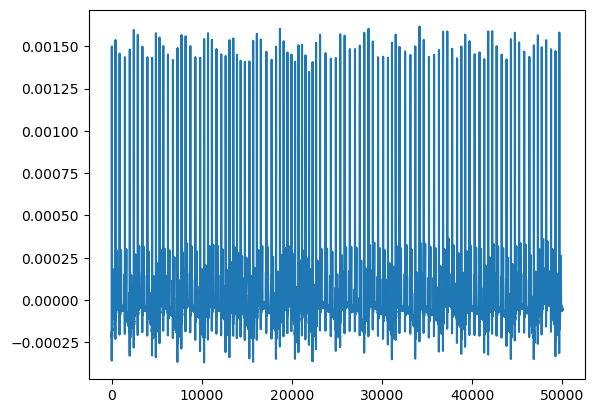

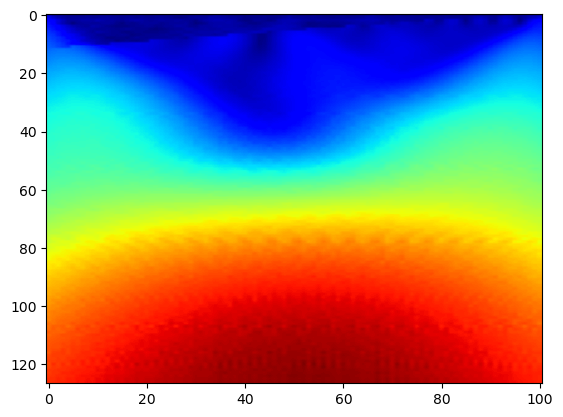

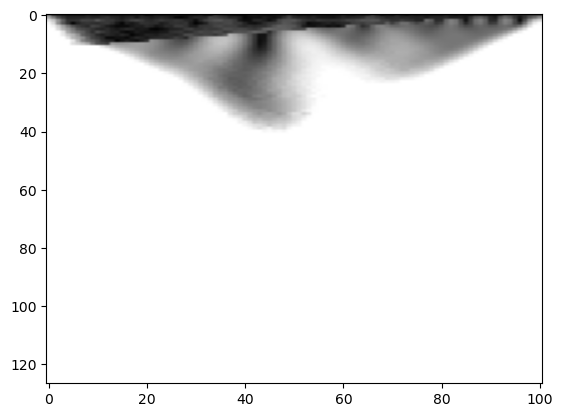

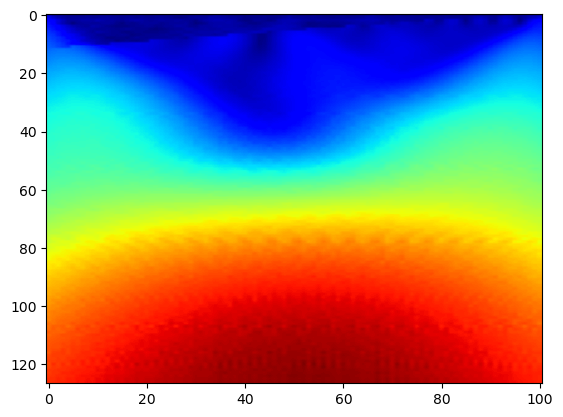

In [104]:
ex_ind = 950
ex = r_peaks_diffs[ex_ind]
plt.plot(data_wide[ex_ind])
plt.show()
s = np.arange(1,128)
#ex_normalized = normalize_1(ex)
ex_cwt = calculate_cwt(ex, s)
plt.imshow(ex_cwt, cmap='jet', aspect='auto',
               vmax=abs(ex_cwt).max(), )
plt.show()
im = Image.fromarray(ex_cwt)

plt.imshow(im, cmap='jet', aspect='auto',
               vmax=abs(ex_cwt).max(), )
plt.show()
np_from_im = np.array(im)
plt.imshow(np_from_im, cmap='jet', aspect='auto',
               vmax=abs(ex_cwt).max(), )

In [ ]:
import csv
def write_peaks_csv(peaks, stage):
    with open('r_peaks/') as f:
        for p in peaks:
            f.write(str(item) for item in p )


In [105]:
#print(im.shape)
im.save('delete.tiff')
loaded_im = Image.open('delete.tiff')
loaded_im


ValueError: Could not save to PNG for display

<PIL.TiffImagePlugin.TiffImageFile image mode=F size=101x127>

In [106]:
images_5[100].shape

(128, 94)

In [125]:
save_as_np(images_5, 5)
save_as_np(images_2, 2)

In [107]:
save_as_images(images_2, 2)
save_as_images(images_5,5)

CWT From scaleogram i don't know how d_t should be when we have difference between peaks

In [59]:
# max_shape of the signal in this case
max(images_5, key=lambda x: x.shape[1]).shape

(128, 141)

/home/tadeusz/miniconda3/envs/tf/lib/python3.9/site-packages/pywt/_functions.py:143: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)
/home/tadeusz/miniconda3/envs/tf/lib/python3.9/site-packages/scaleogram/wfun.py:173: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = pywt.DiscreteContinuousWavelet(wavelet)


ValueError: Selected scale of 0.05555555555555555 too small.

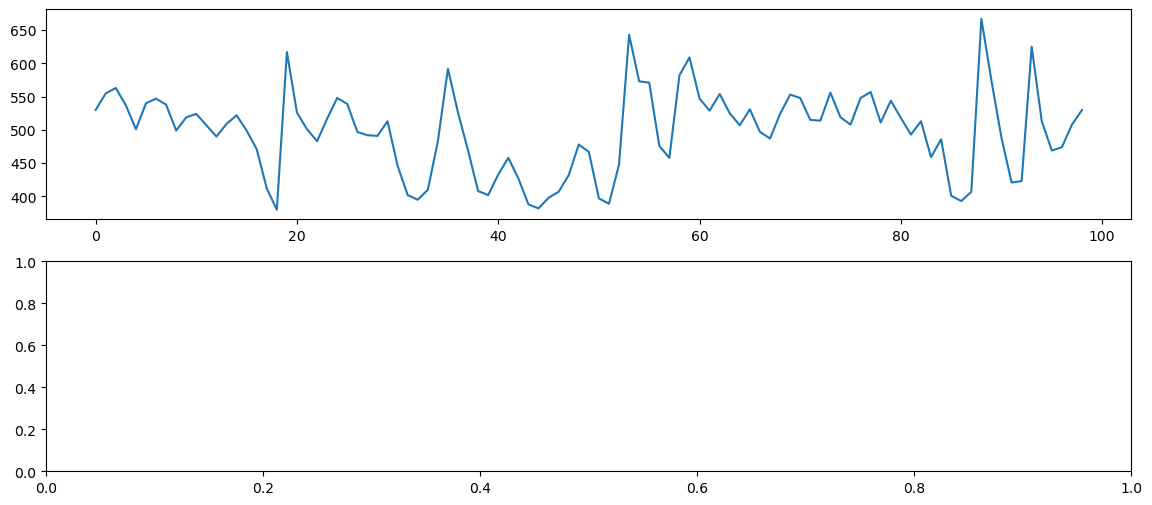

In [90]:
import scaleogram as scg
time = np.arange(len(ex))
wavelet = 'cmor'
d_t = 1
a = pywt.central_frequency(wavelet) / (d_t * s)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 6))
ax1.plot(time, ex)
ax2 = scg.cws(np.arange(len(ex)),ex, scales=a, wavelet=wavelet,yaxis='frequency',spectrum='power',
 ax=ax2, cmap="jet", ylabel="f [Hz]", xlabel="Time [seconds]",
 yscale='linear')


In [ ]:
import scipy.fftpack as fftpack
N = len(ex)
d_t  =1
freqs = np.linspace(0,N/(2*d_t), N//2)
fft=fftpack.fft(ex)
fft_power = np.abs(fft[:N//2])**2
plt.plot(freqs,fft_power)

In [ ]:
sus = data_wide[17006]
plt.plot(sus)
plt.plot(ex_cleaned)
sus_peaks = neurokit2.ecg_peaks(ex_cleaned[:15000], sampling_rate=500)
sus_peaks

In [ ]:
noise = np.concatenate(data[17001:17026])
plt.plot(noise)
plt.plot(data[110])

In [ ]:
sus_peaks = neurokit2.ecg_peaks(ex_cleaned[:10000])

In [ ]:
def plot_with_peaks(y, r_peaks, detector_name='nodetect', sampling_freq=500):
    # convert sample to nr to time
    r_ts = np.array(r_peaks) / sampling_freq
    # plotting
    plt.figure()
    t = np.linspace(0, len(y) / sampling_freq, len(y))
    plt.plot(t, y)
    plt.plot(r_ts, y[r_peaks], 'ro')
    plt.title(f"{detector_name}")
    plt.ylabel("ECG/mV")
    plt.xlabel("time/sec")
    plt.show()

In [ ]:
ex_data = data_wide[100]
ex = neurokit2.ecg_peaks(ex_data, sampling_rate=500)[1]['ECG_R_Peaks']
plot_with_peaks(ex_data, ex)